https://colab.research.google.com/drive/1s8m6WQbR88u9B9981e-iy4JlUCppG1mG

# CODE 10: Playing Naively with Learning Rates

_"Stop playing god, that's morgan's job, don't mess naively with **Learning Rates**"_   --Successful Student

Target:

1. Add LR Scheduler
2. Results:
    1. Parameters: 13.8k
    2. Best Train Accuracy: 99.21
    3. Best Test Accuracy: 99.45 (9th Epoch), 99.48 (20th Epoch)
3. Analysis:
    1. Finding a good LR schedule is hard. We have tried to make it effective by reducing LR by the 10th after the 6th epoch.
    2. It did help in getting to 99.4 or faster, but the final accuracy is not more than 99.5. Possibly a good scheduler can do wonders here!

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 205331419.96it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 12614359.45it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 68000190.72it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15589630.74it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [ ]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.13546454906463623 Batch_id=468 Accuracy=86.80: 100%|██████████| 469/469 [00:29<00:00, 15.75it/s]



Test set: Average loss: 0.0655, Accuracy: 9813/10000 (98.13%)

EPOCH: 1


Loss=0.08001220971345901 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:22<00:00, 20.80it/s]



Test set: Average loss: 0.0400, Accuracy: 9878/10000 (98.78%)

EPOCH: 2


Loss=0.0536758191883564 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:22<00:00, 20.49it/s]



Test set: Average loss: 0.0318, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Loss=0.10773385316133499 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]



Test set: Average loss: 0.0288, Accuracy: 9909/10000 (99.09%)

EPOCH: 4


Loss=0.049423400312662125 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:26<00:00, 17.84it/s]



Test set: Average loss: 0.0320, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.06574732065200806 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]



Test set: Average loss: 0.0256, Accuracy: 9920/10000 (99.20%)

EPOCH: 6


Loss=0.060677338391542435 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s]



Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.023230433464050293 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:23<00:00, 19.85it/s]



Test set: Average loss: 0.0219, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.03589601069688797 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:21<00:00, 21.52it/s]



Test set: Average loss: 0.0232, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.08764439821243286 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]



Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.040558915585279465 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:21<00:00, 21.39it/s]



Test set: Average loss: 0.0216, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.025339946150779724 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:21<00:00, 21.54it/s]



Test set: Average loss: 0.0202, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.008392252959311008 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]



Test set: Average loss: 0.0226, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.028040634468197823 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:23<00:00, 20.19it/s]



Test set: Average loss: 0.0233, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.03529603034257889 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:25<00:00, 18.54it/s]



Test set: Average loss: 0.0212, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.0667828693985939 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:23<00:00, 20.34it/s]



Test set: Average loss: 0.0221, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.021697329357266426 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s]



Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.006857152562588453 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:23<00:00, 19.75it/s]



Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.02798357605934143 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:24<00:00, 19.13it/s]



Test set: Average loss: 0.0175, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.0014073350466787815 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:23<00:00, 19.99it/s]



Test set: Average loss: 0.0179, Accuracy: 9936/10000 (99.36%)



# Let's Train and test our model

This time let's add a scheduler for out LR.

Text(0.5, 1.0, 'Test Accuracy')

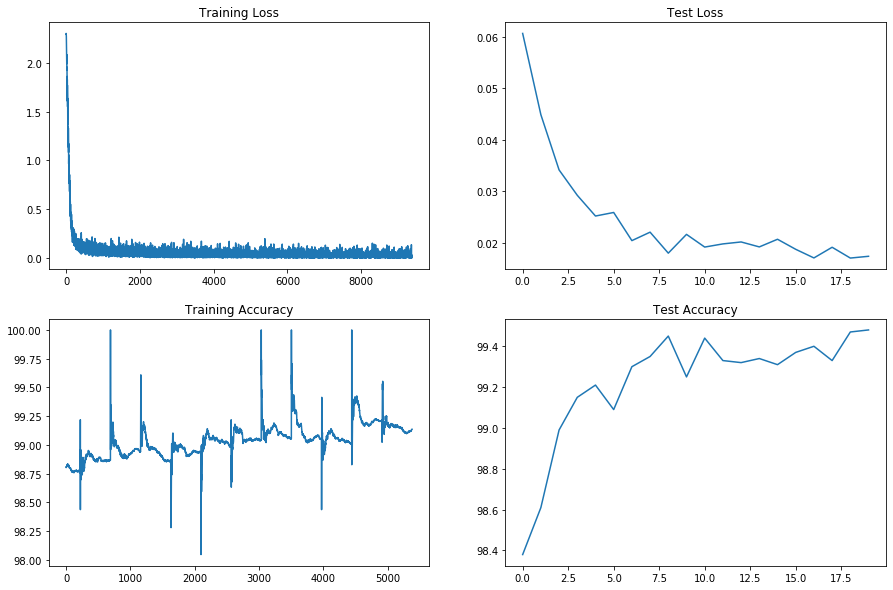

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")